# Testing Conditional Diffusion Model for Metasurfaces

This notebook demonstrates the process of:
1. **Loading trained model** - conditional diffusion model
2. **Generating samples** - creating new metasurfaces
3. **Quality analysis** - computing MPE loss for each sample
4. **Selecting best sample** - based on minimum loss
5. **Visualizing results** - plots and 2D representations

In [31]:
import json

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import torch
from huggingface_hub import hf_hub_download

from diffusion_model.conditional_network.conditional_decoder import (
    Decoder_conditional_diffusion_vector,
)
from diffusion_model.conditional_network.conditional_model import Diffusion_model

## Model Parameter Configuration

To train your own model you can either download our dataset consisting of 11,000 samples of 2x2 metasurfaces with the spheres' refractive index equals 2 or create your own with the same structure:

In [4]:
try:
    print("Downloading from huggingface_hub...")
    dataset = hf_hub_download(
        repo_id="mikzuker/inverse_design_diffusion",
        filename="conditional_dataset_11000.csv",
    )
    print("Complete")

except Exception as e:
    print("⚠️ Fail", e)
    print(
        "Put a dataset file into /workspace/diffusion_model/conditional_csv_datasets directory"
    )
    dataset = "/workspace/diffusion_model/conditional_csv_datasets/conditional_dataset_11000.csv"

Complete


To train and sample using the model use the following script:

In [ ]:
model = Diffusion_model(
    milestone=1, use_film=True, dataset_file_path=dataset
)  # You can specify milestone number to save model weights
model.__train__()
sampled_seq = model.__sample__(
    batch_size=1,
    conditional_vec=torch.tensor(
        [[0.3, 0.1, 0.05, 0.03, 0.01, 0.04, 0.08, 0.1, 0.09, 0.15]], dtype=torch.float32
    ),
)  # Conditional vector for sampling is desired DSCS values on specified polar angles
print(sampled_seq, sampled_seq.shape)

If you want to use trained model, you can download weights using Hugging Face:

In [6]:
try:
    print("Downloading from huggingface_hub...")
    weights_path = hf_hub_download(
        repo_id="mikzuker/inverse_design_diffusion", filename="model.pt"
    )
    print("Complete")

except Exception as e:
    print("⚠️ Fail", e)
    print(
        "Put a model.pt file into /workspace/diffusion_model/Conditional_Model_16_2_4e-6_11000_20000 directory"
    )
    weights_path = (
        "/workspace/diffusion_model/Conditional_Model_16_2_4e-6_11000_20000/model.pt"
    )

Complete


In [7]:
model = Diffusion_model(
    use_film=True,  # Use FiLM layers for conditional input
    model_path=weights_path,
)

## Sample Generation and Analysis

Here we will solve inverse design problem for the Groundtruth Metasurface that was not previously seen by the model during the training process. All parameters of the Grountruth Metasurface can be find the folder of the same name.

In [26]:
losses = []
relative_geometry_vectors = []

sample_set_size = 3
batch_size_to_sample = 1

# Conditional vector for sampling (DSCS spectrum of the Groundtruth Metasurface)
conditional_vector_for_sampling = [
    0.2440047233652012,
    0.13373316545853187,
    0.02412256686224966,
    0.01539638601171363,
    0.01649837827339581,
    0.01732019799698209,
    0.02093668041765947,
    0.011067599422850802,
    0.06566540324909036,
    0.7599160673969182,
]

# Sample generation loop
for i in range(sample_set_size):
    print(f"Generation, {i + 1}/{sample_set_size} sample...")
    print("=" * 50)

    # Generate new vector using diffusion model
    vector_to_decode = model.__sample__(
        batch_size=batch_size_to_sample,
        conditional_vec=torch.tensor([conditional_vector_for_sampling]),
    )

    # Create decoder to transform generated vector into physical parameters
    decoder = Decoder_conditional_diffusion_vector(
        vector_to_decode,
        angles=[
            10,
            20,
            40,
            60,
            70,
            80,
            100,
            120,
            140,
            160,
        ],  # angles at which DSCS values are specified as conditioning vector
        number_of_cells=2,  # number of cells in the metasurface
        side_length=10,  # side length of the metasurface
        reflective_index=2,  # reflective index of the metasurface's spheres
        vacuum_wavelength=1,  # vacuum wavelength
        conditional_dscs_surface=conditional_vector_for_sampling,  # conditioning vector of DSCS values
    )

    # Compute physical surface and DSCS spectrum
    print("Computing physical surface...")
    dscs_surface = decoder.compute_sphere_surface()

    # Compute MPE loss (Mean Percentage Error)
    loss = decoder.compute_loss()

    # Store results for analysis
    relative_geometry_vectors.append(vector_to_decode)
    losses.append(loss)

    print(f"MPE value: {loss}")
    print(f"Relative geometry vector: {vector_to_decode}")

Generation, 1/3 sample...
loading from version 2.1.1


/workspace/diffusion_model/conditional_network/conditional_diffusion_pytorch_1d.py:1095: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(model_path, map_loca

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing physical surface...
Evaluating scattered field plane wave expansion in layer number 1 ...
Scatt. field pwe          : 100%|██████████| elapsed: 00:00 remaining: 00:00
Evaluating scattered field plane wave expansion in layer number 0 ...
Scatt. field pwe          : 100%|██████████| elapsed: 00:00 remaining: 00:00
MPE value: 12.029038106875888
Relative geometry vector: tensor([[[0.2096, 0.0867, 0.1690, 0.5613, 0.7632, 0.7878, 0.1207, 0.6342,
          0.9667, 0.3156, 0.7638, 0.9947, 0.0054, 0.0072, 0.0099, 0.0000]]])
Generation, 2/3 sample...
loading from version 2.1.1


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing physical surface...
Evaluating scattered field plane wave expansion in layer number 1 ...
Scatt. field pwe          : 100%|██████████| elapsed: 00:00 remaining: 00:00
Evaluating scattered field plane wave expansion in layer number 0 ...
Scatt. field pwe          : 100%|██████████| elapsed: 00:00 remaining: 00:00
MPE value: 24.592651271338642
Relative geometry vector: tensor([[[3.5942e-01, 8.5762e-01, 9.6461e-02, 2.6679e-01, 5.8960e-01,
          5.0419e-01, 1.8015e-01, 8.6639e-01, 7.1105e-01, 9.5520e-01,
          8.1932e-01, 1.0000e+00, 3.2513e-02, 0.0000e+00, 1.7524e-05,
          6.0889e-04]]])
Generation, 3/3 sample...
loading from version 2.1.1


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing physical surface...
Evaluating scattered field plane wave expansion in layer number 1 ...
Scatt. field pwe          : 100%|██████████| elapsed: 00:00 remaining: 00:00
Evaluating scattered field plane wave expansion in layer number 0 ...
Scatt. field pwe          : 100%|██████████| elapsed: 00:00 remaining: 00:00
MPE value: 13.41517110442413
Relative geometry vector: tensor([[[0.2660, 0.2354, 0.8814, 0.8609, 0.6057, 0.3865, 0.6807, 0.8007,
          0.3879, 0.2714, 0.4845, 0.9190, 0.0000, 0.0118, 0.0000, 0.0000]]])


In [27]:
min_loss = min(losses)
min_loss_index = losses.index(min_loss)
min_loss_vector = relative_geometry_vectors[min_loss_index]

print(f"Best MPE Value: {min_loss}")
print(f"Best MPE Value related geometry vector: {min_loss_vector}")

Best MPE Value: 12.029038106875888
Best MPE Value related geometry vector: tensor([[[0.2096, 0.0867, 0.1690, 0.5613, 0.7632, 0.7878, 0.1207, 0.6342,
          0.9667, 0.3156, 0.7638, 0.9947, 0.0054, 0.0072, 0.0099, 0.0000]]])


## Creating Decoder for Best Sample

Now we create a special decoder for the sample with the best MPE Value
to analyze its properties in detail and visualize the results:

Evaluating scattered field plane wave expansion in layer number 1 ...
Scatt. field pwe          : 100%|██████████| elapsed: 00:00 remaining: 00:00
Evaluating scattered field plane wave expansion in layer number 0 ...
Scatt. field pwe          : 100%|██████████| elapsed: 00:00 remaining: 00:00


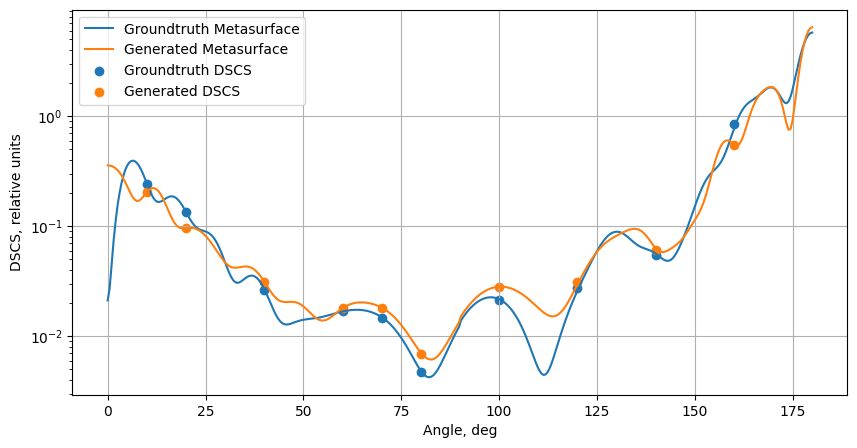

In [28]:
decoder_best_loss = Decoder_conditional_diffusion_vector(
    min_loss_vector,
    angles=[10, 20, 40, 60, 70, 80, 100, 120, 140, 160],
    number_of_cells=2,
    side_length=10,
    reflective_index=2,
    vacuum_wavelength=1,
    conditional_dscs_surface=conditional_vector_for_sampling,
)

decoder_best_loss.compute_sphere_surface()

decoder_best_loss.compute_loss()

dscs_surface = (
    decoder_best_loss.dscs_surface
)  # DSCS spectrum of the generated metasurface
with open("/workspace/groundtruth metasurface/dscs_surface.json", "r") as f:
    groundtruth_dscs = json.load(f)  # DSCS spectrum of the groundtruth metasurface

angles = [10, 20, 40, 60, 70, 80, 100, 120, 140, 160]

groundtruth_dscs_target = [
    groundtruth_dscs[i * 2] for i in angles
]  # DSCS values of the groundtruth metasurface on specified angles

surface_dscs_target = (
    decoder_best_loss.dscs_surface_points
)  # DSCS values of the generated metasurface on specified angles

plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 180, 360), groundtruth_dscs, label="Groundtruth Metasurface")
plt.plot(np.linspace(0, 180, 360), dscs_surface, label="Generated Metasurface")
plt.scatter(angles, groundtruth_dscs_target, label="Groundtruth DSCS")
plt.scatter(angles, surface_dscs_target, label="Generated DSCS")
plt.xlabel("Angle, deg")
plt.ylabel("DSCS, relative units")
plt.yscale("log")
plt.grid(True)
plt.legend()

## Metasurface Geometry Visualization

Now we can see the projections of both metasurfaces:

### Generated Metasurface

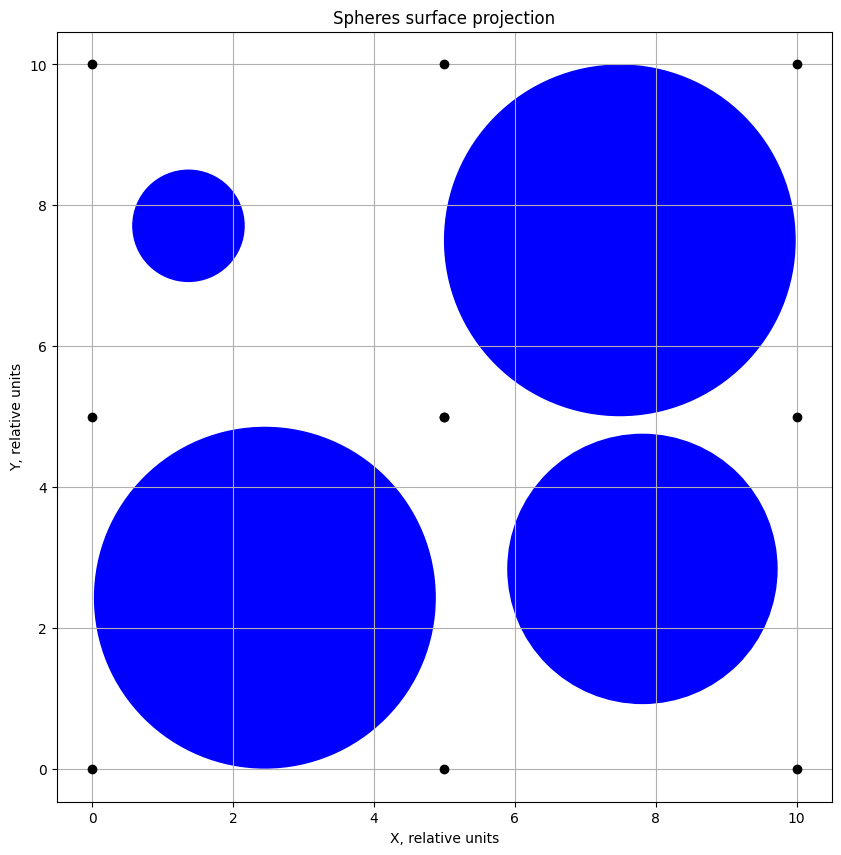

In [29]:
# save_path - path to save the plots (DSCS plot and 2D projection)
decoder_best_loss.sphere_surface.spheres_plot(
    save_path="/workspace/diffusion_model/sphere_surface.pdf"
)

### Groundtruth Metasurface

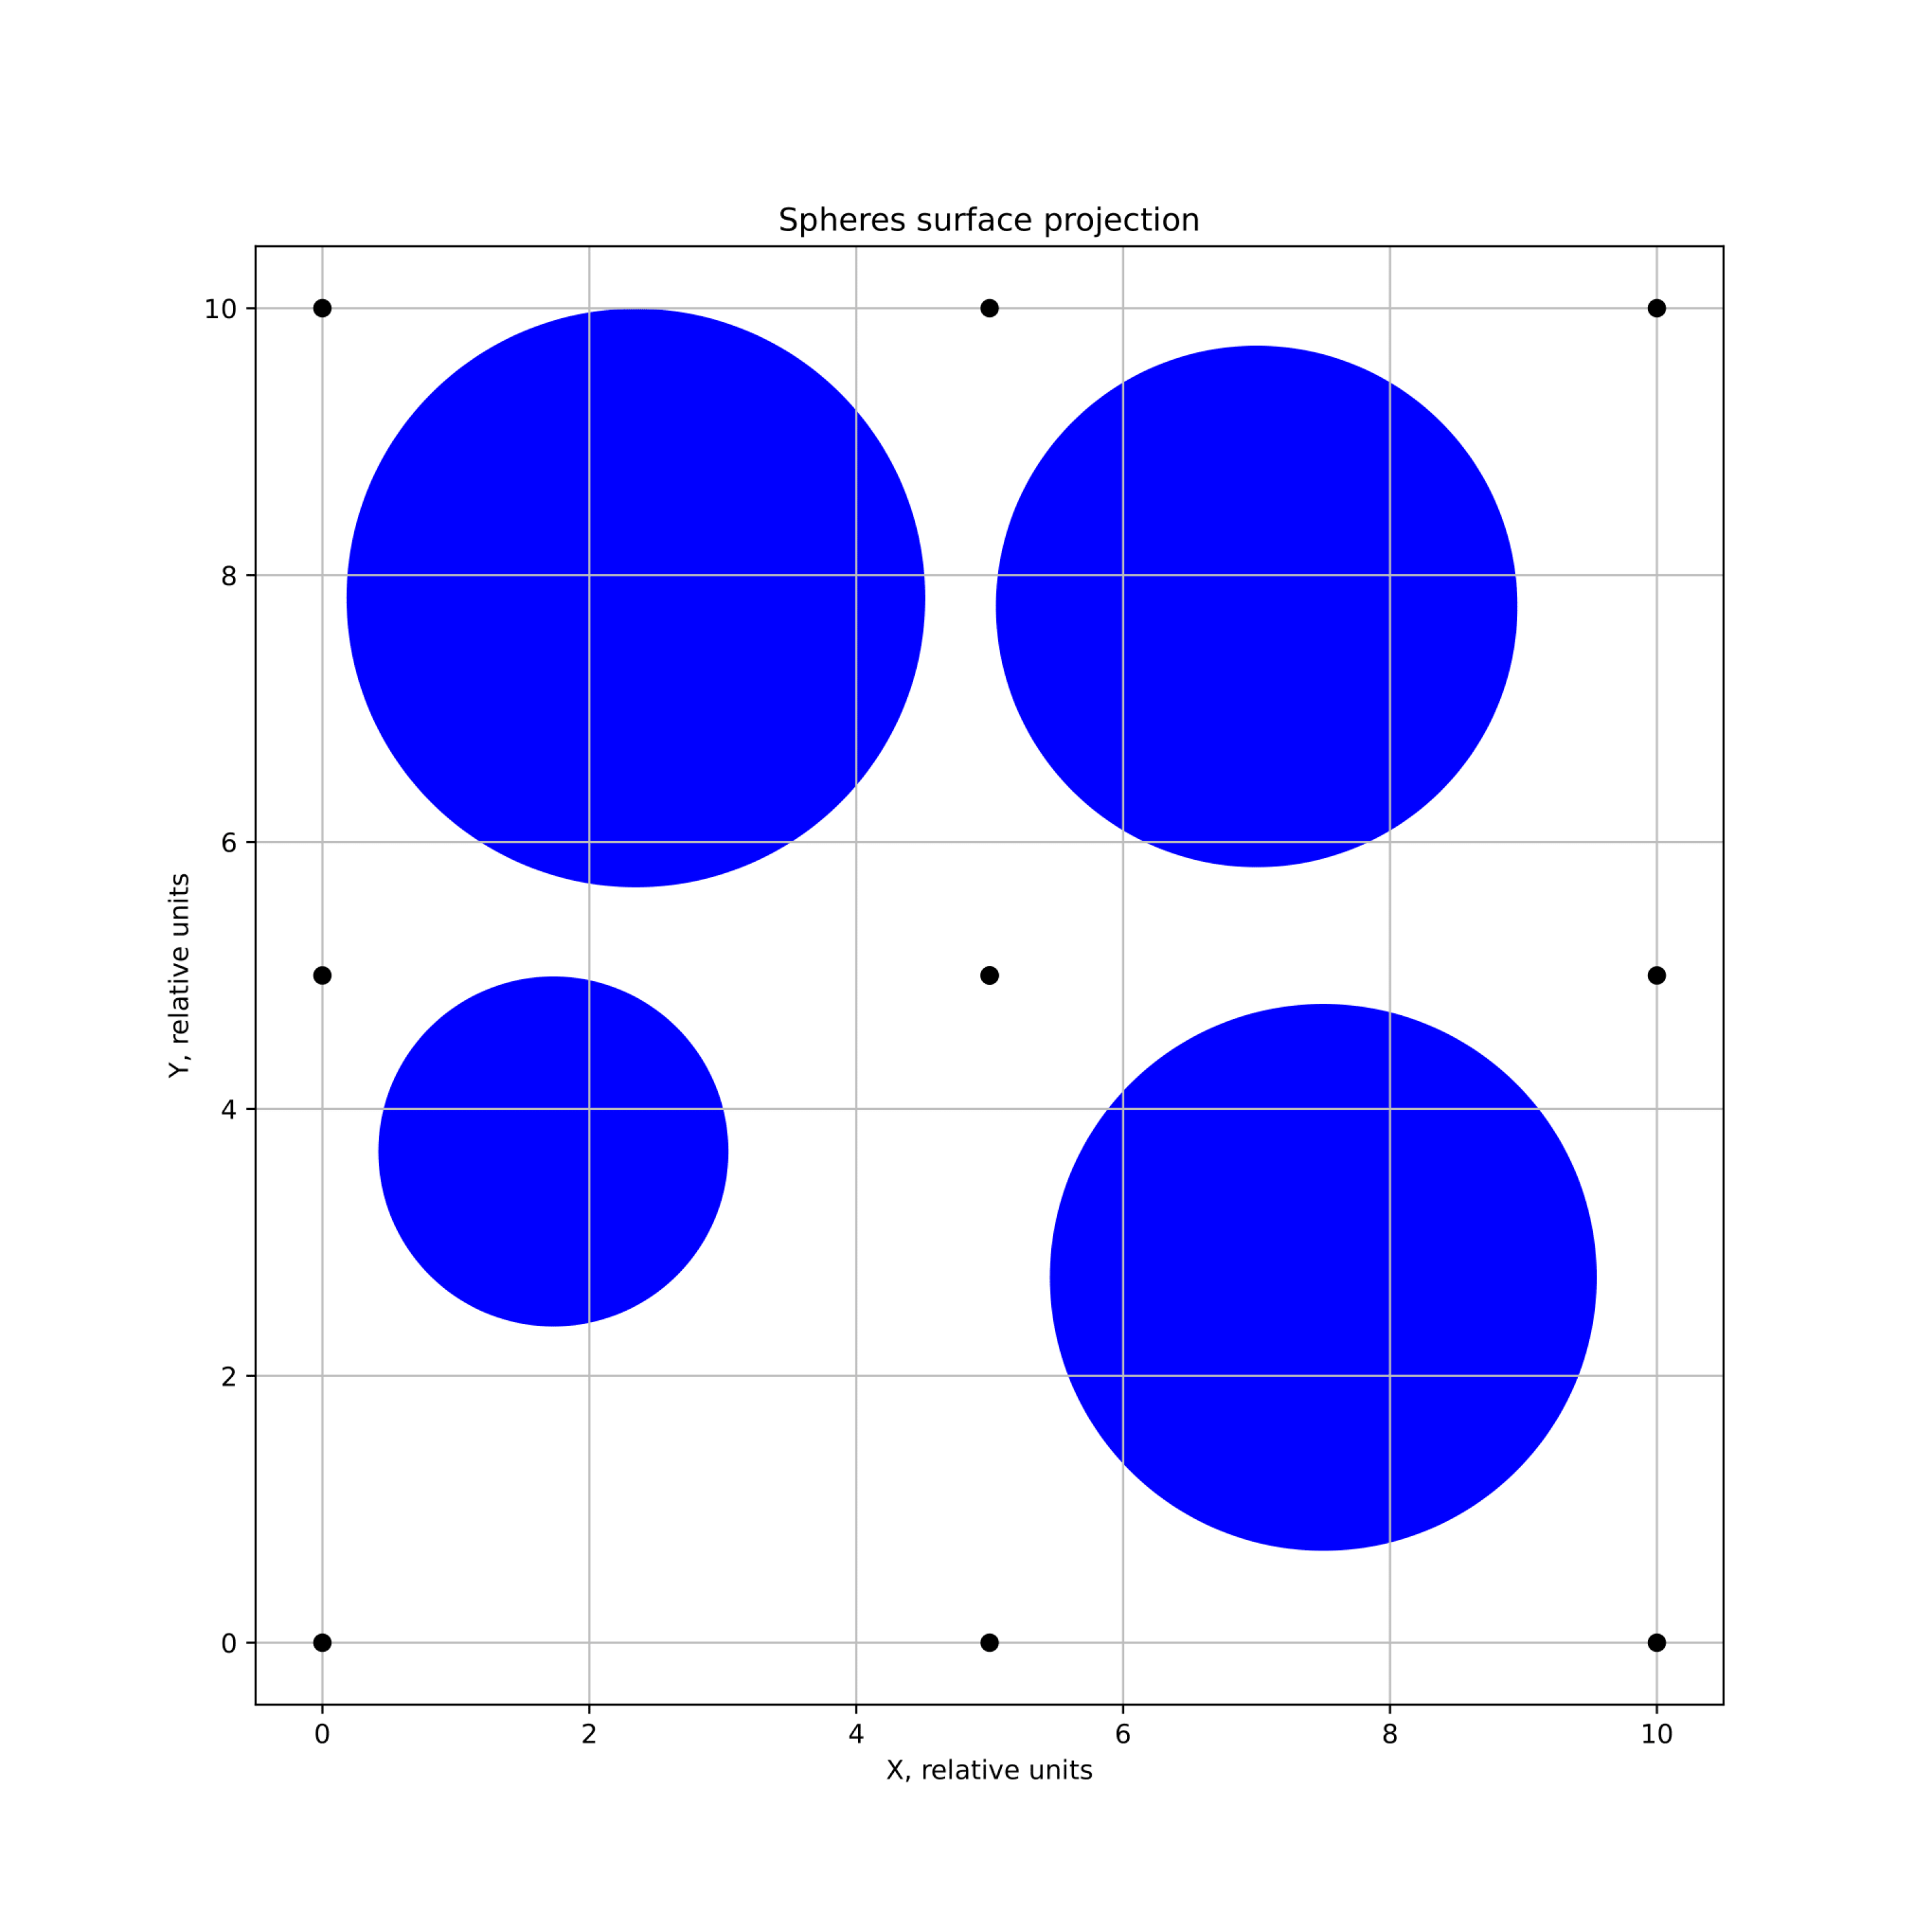

In [30]:
img = mpimg.imread("/workspace/groundtruth metasurface/spheres_surface_projection.png")
plt.figure(figsize=(10, 10), dpi=300)
plt.imshow(img)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()